In [8]:
import numpy as np
import tensorflow as tf
import time
from tqdm import tqdm
import os
import sys

with open('.env','r') as env:
    tffm_path = env.read()
sys.path.append(tffm_path)

SEED = 42

/Users/YuLong/miniconda3/envs/py_37_ds/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/YuLong/miniconda3/envs/py_37_ds/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/YuLong/miniconda3/envs/py_37_ds/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/YuLong/miniconda3/envs/py_3

# Data

In [9]:
from tensorflow.examples.tutorials.mnist import input_data
# from sklearn.datasets import fetch_mldata
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

print('-----END IMPORT MESSAGE------ \n\n\n')

# dataset = fetch_openml("mnist_784")
mnist = input_data.read_data_sets("MNIST_data/")

mnist_images = mnist.train.images
mnist_labels = mnist.train.labels

n_three, n_five = sum(mnist_labels==3), sum(mnist_labels==5)

X_all = np.vstack([
    mnist_images[mnist_labels==3,:],
    mnist_images[mnist_labels==5,:]
])

y_all = np.array([1] * n_three + [0] * n_five)
# make it more sparse
X_all = X_all * (np.random.uniform(0, 1, X_all.shape) > 0.8)


print('Dataset shape: {}'.format(X_all.shape))
print('Non-zeros rate: {:.05f}'.format(np.mean(X_all != 0)))
print('Classes balance: {:.03f} / {:.03f}'.format(np.mean(y_all==0), np.mean(y_all==1)))

X_tr, X_te, y_tr, y_te = train_test_split(X_all, y_all, random_state=SEED, test_size=0.3)

-----END IMPORT MESSAGE------ 



Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Dataset shape: (10625, 784)
Non-zeros rate: 0.04033
Classes balance: 0.469 / 0.531


In [12]:
import scipy.sparse as sp
# only CSR format supported
X_tr_sparse = sp.csr_matrix(X_tr)
X_te_sparse = sp.csr_matrix(X_te)

# Different optimizers

In [10]:
from tffm import TFFMClassifier
import matplotlib.pyplot as plt

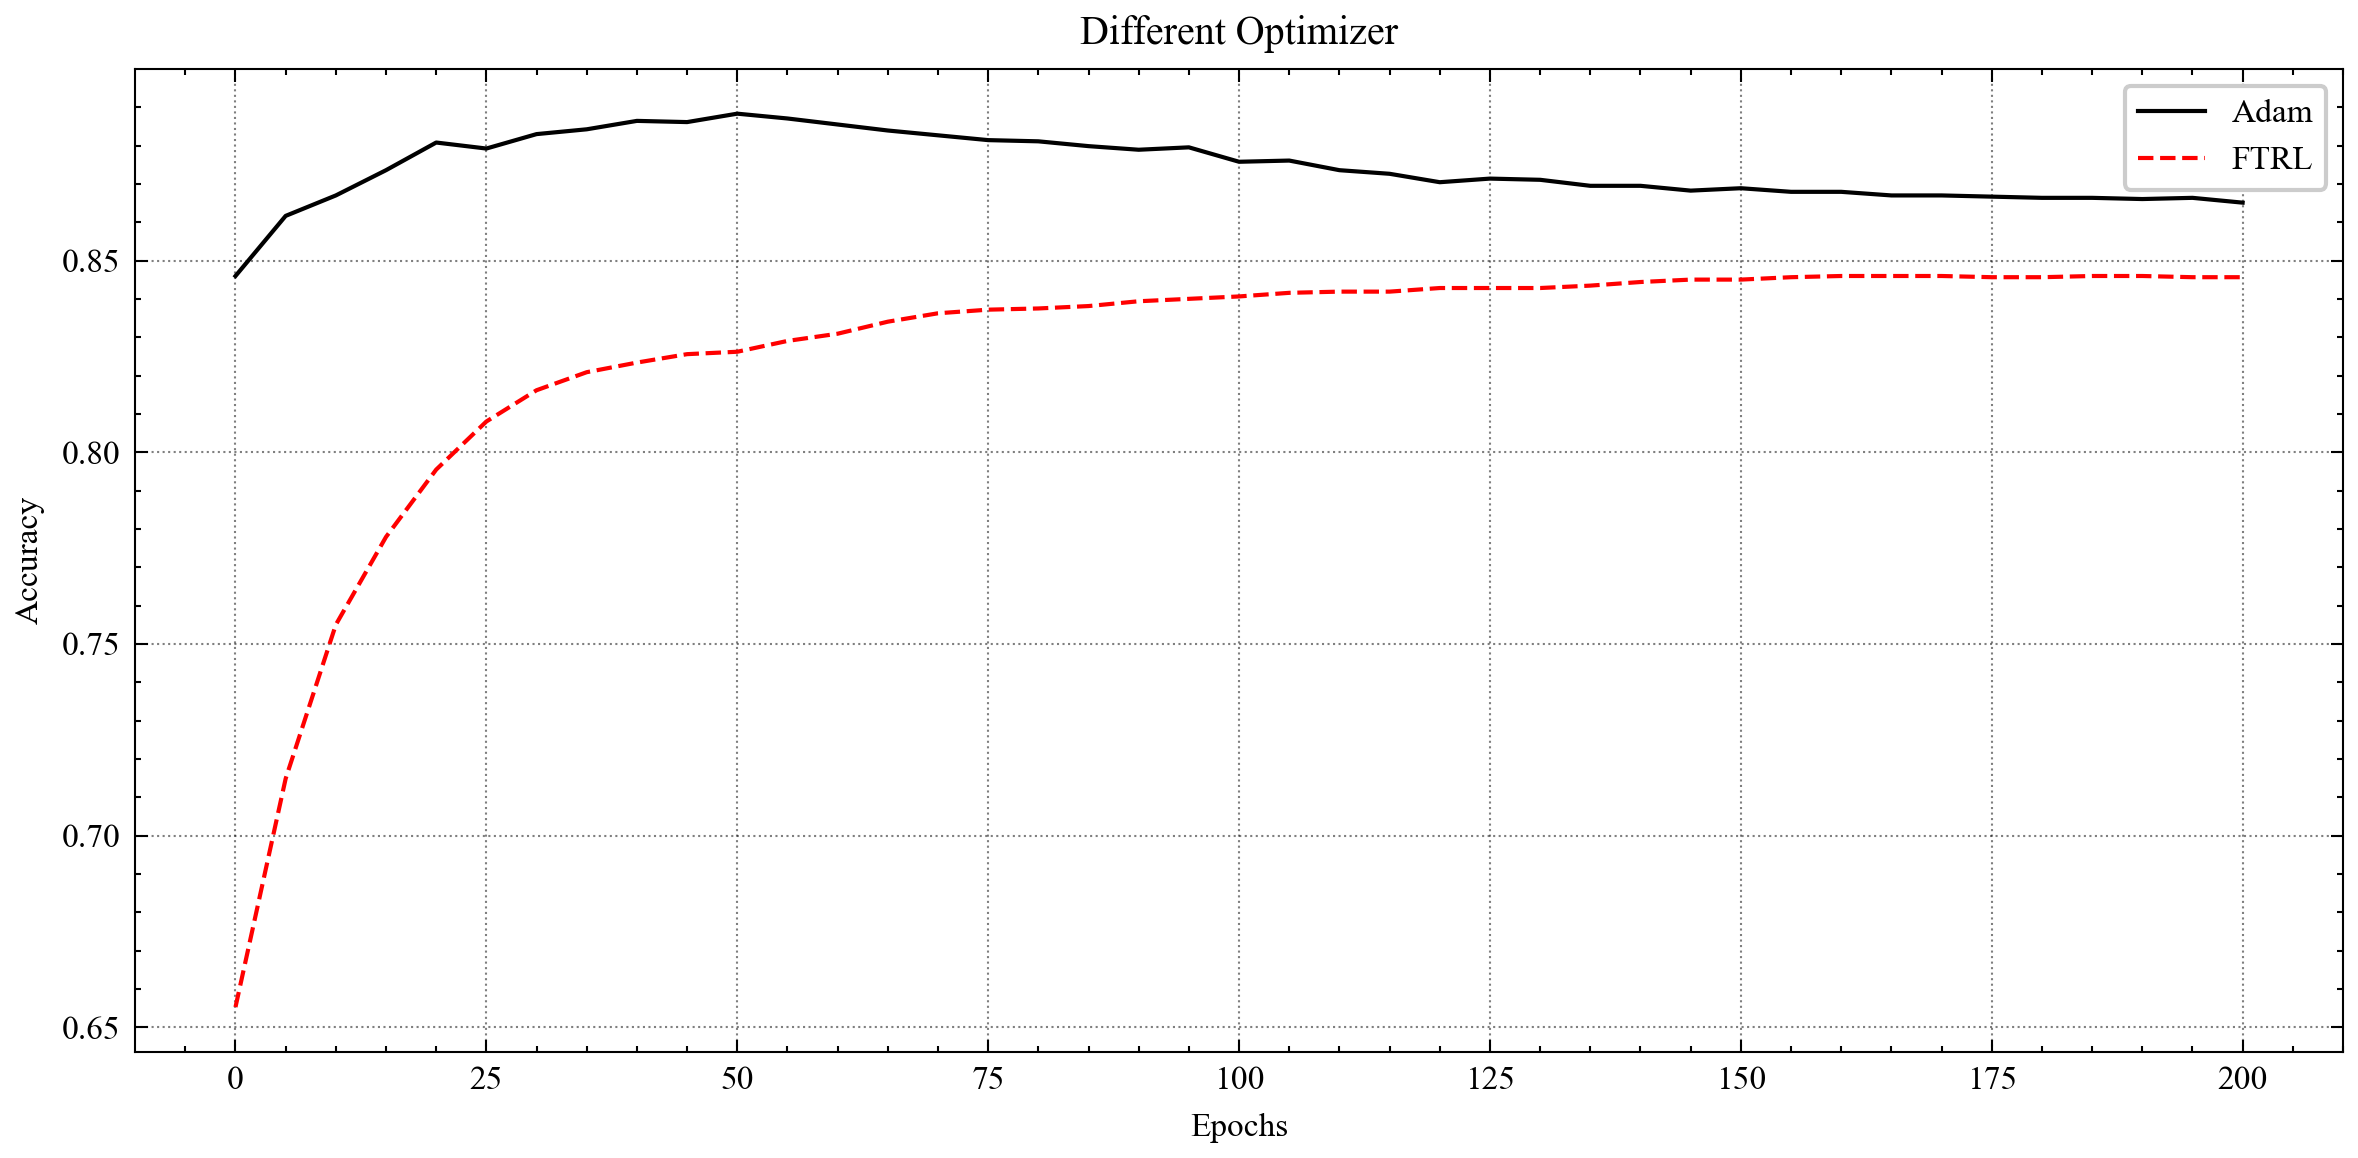

In [30]:
opts_tuple = [(tf.train.AdamOptimizer(learning_rate=0.001), 'Adam'), 
                  (tf.train.FtrlOptimizer(0.01, l1_regularization_strength=0.01), 'FTRL')]

with plt.style.context(['science', 'ieee','grid', 'no-latex']):
    fig, ax = plt.subplots(figsize=(8,4), dpi=300)
    for optim, title in opts_tuple:
        acc = []
        model = TFFMClassifier(
            order=2, 
            rank=100, 
            optimizer=optim,
            batch_size=1024,
            init_std=0.001,
            reg=0.1,
            input_type='sparse',
        )
        n_epochs = 5
        anchor_epochs = range(0, 200+1, n_epochs)
        for _ in anchor_epochs:
            # score result every 5 epochs
            model.fit(X_tr_sparse, y_tr, n_epochs=n_epochs)
            predictions = model.predict(X_te_sparse)
            acc.append(accuracy_score(y_te, predictions))
        ax.plot(anchor_epochs, acc,label=title)
    ax.set(title='Different Optimizer')
    ax.set(xlabel='Epochs')
    ax.set(ylabel='Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()
    


# Different number of latent factors

This is time comsuming task

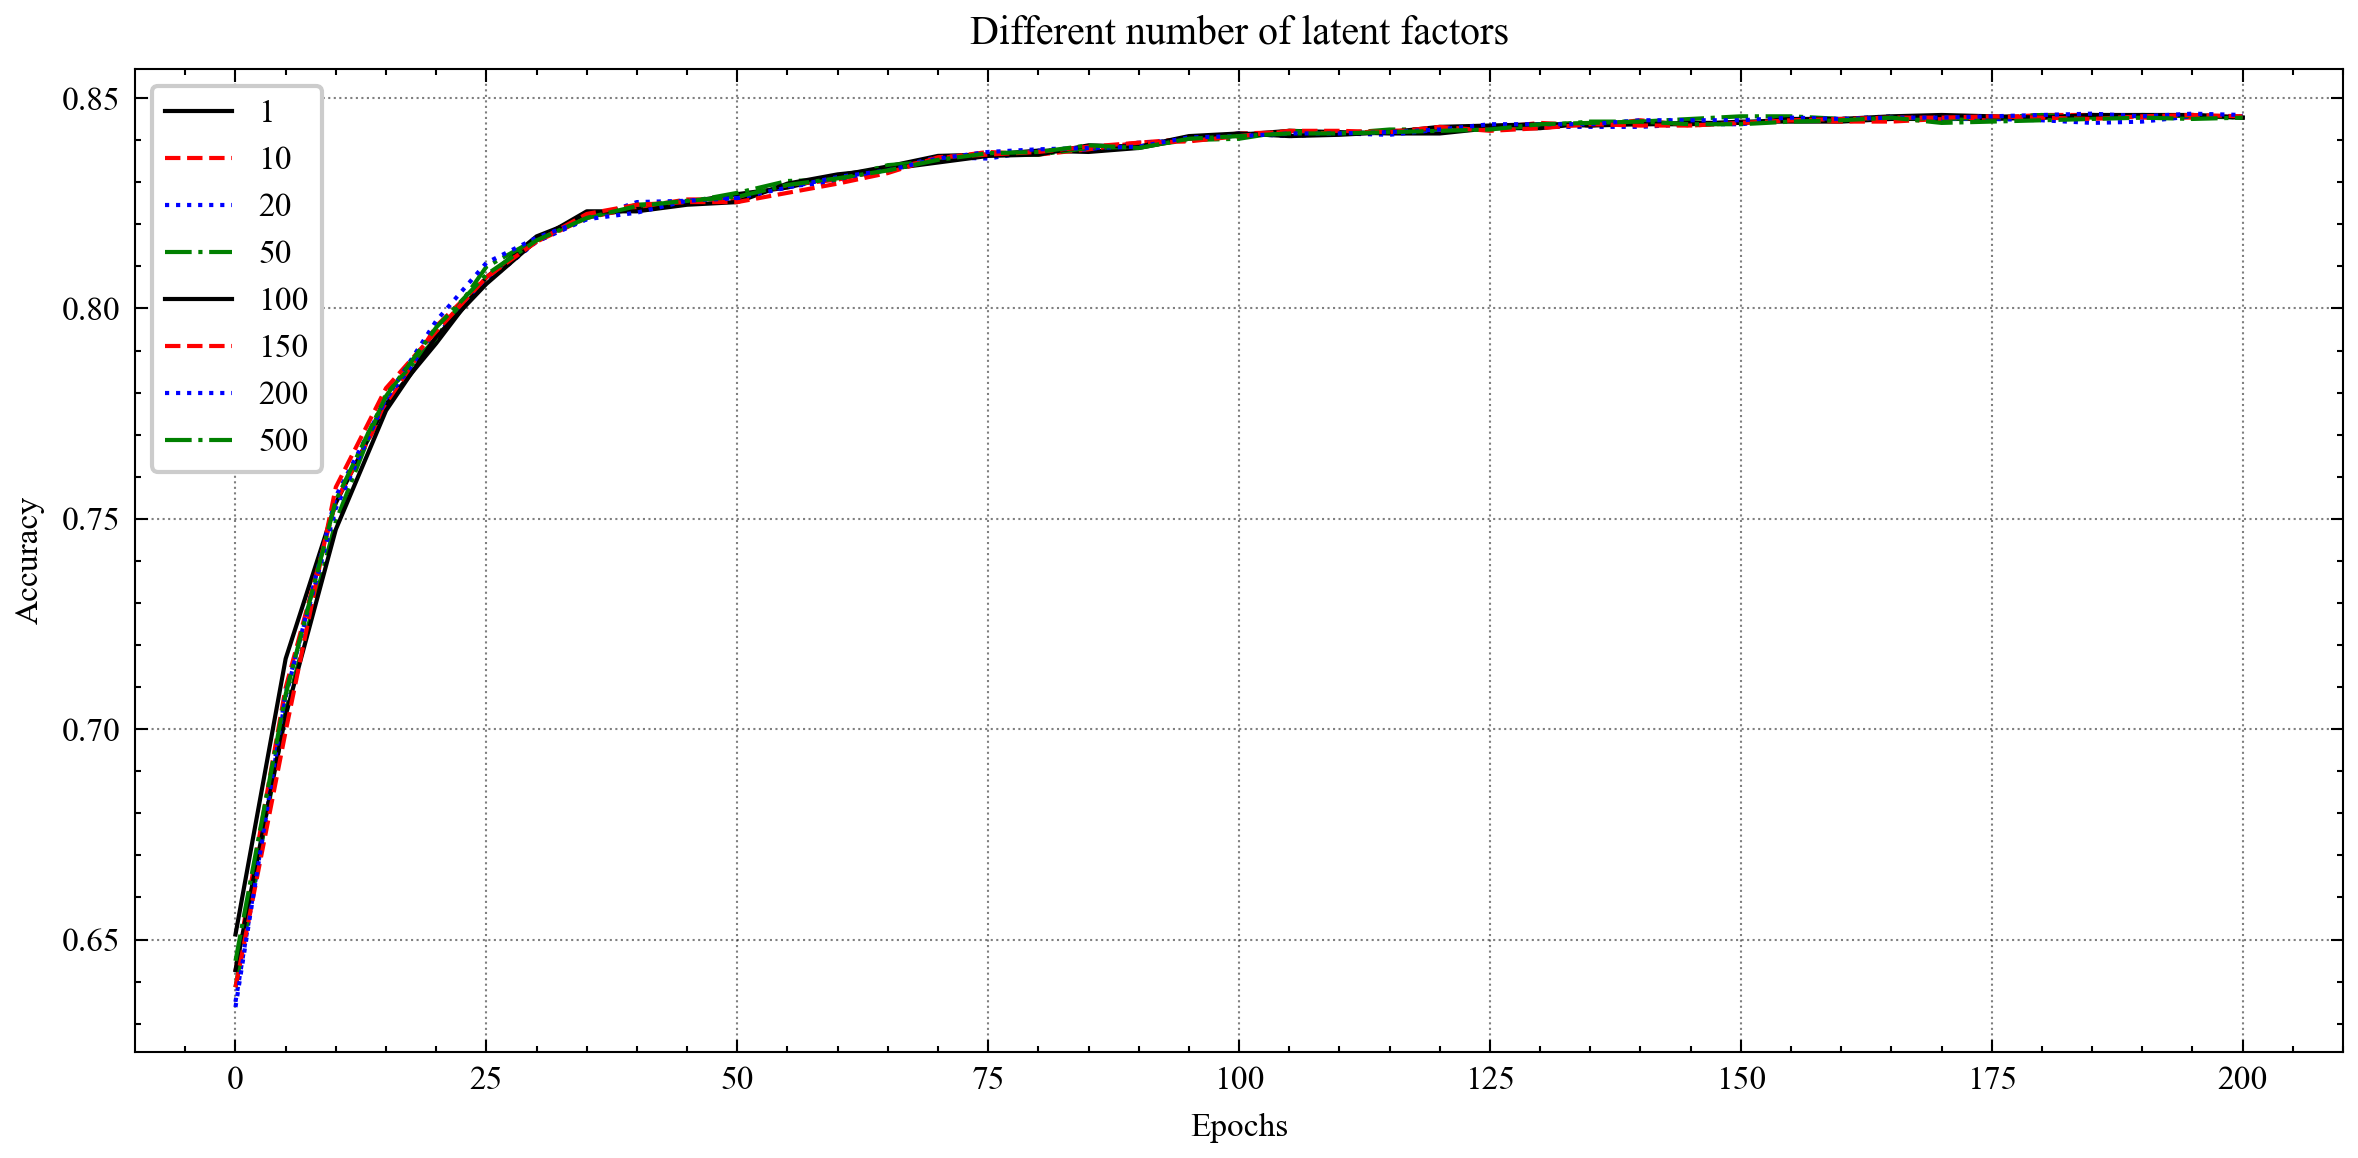

In [31]:
n_latent_factor = [1, 10, 20, 50, 100, 150, 200, 500]
with plt.style.context(['science', 'ieee','grid', 'no-latex']):
    fig, ax = plt.subplots(figsize=(8,4), dpi=300)
    for curr_num_latent_factor in n_latent_factor:
        acc = []
        model = TFFMClassifier(
            order=2, 
            rank=curr_num_latent_factor, 
            optimizer=tf.train.AdamOptimizer(learning_rate=0.001),
            batch_size=1024,
            init_std=0.001,
            reg=0.1,
            input_type='sparse',
        )
        n_epochs = 5
        anchor_epochs = range(0, 200+1, n_epochs)
        for _ in anchor_epochs:
            # score result every 5 epochs
            model.fit(X_tr_sparse, y_tr, n_epochs=n_epochs)
            predictions = model.predict(X_te_sparse)
            acc.append(accuracy_score(y_te, predictions))
        ax.plot(anchor_epochs, acc,label=str(curr_num_latent_factor))
    ax.set(title='Different number of latent factors')
    ax.set(xlabel='Epochs')
    ax.set(ylabel='Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()